# Final project FDS

Bone fracture detection on x-ray images using a CNN.

Group members: Aiman Nadeem, Thale Krohn-Pettersen, Kirsten Nord.

## Table of contents
1. [Setup and data preprocessing](#setup)
2. [Model definition](#model)
3. [Training and validation](#training)
4. [Analysis](#analysis)

## Setup and data preprocessing <a name="setup"></a>

- Installing required packages
- Importing necessary libraries
- Downloading dataset and re-splitting the dataset into 80% training, 10% validation and 10% testing.

In [4]:
if True:
    #%pip install kagglehub scikit-learn
    #%pip install tensorflow
    #%pip install pillow
    %pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import the required libraries
import os
import random
import shutil
import kagglehub
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision, Recall

/Users/kirsten/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kirsten/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Download the dataset from Kaggle
dataset_path = kagglehub.dataset_download("osamajalilhassan/bone-fracture-dataset")
print(f"Dataset downloaded to {dataset_path}")

Dataset downloaded to /Users/kirsten/.cache/kagglehub/datasets/osamajalilhassan/bone-fracture-dataset/versions/1


In [7]:
def is_image_file(filename):
    return filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', '.tiff'))

def split_dataset(dataset_path, output_path, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1):
    os.makedirs(output_path, exist_ok=True)  # Ensure output directory exists

    splits = ['training', 'testing']
    categories = ['fractured', 'not_fractured']

    for split in splits:
        for category in categories:
            class_dir = os.path.join(dataset_path, split, category)
            
            # Get all image files in the category
            images = [f for f in os.listdir(class_dir) if is_image_file(f)]
            random.shuffle(images)

            # Calculate split sizes
            train_end = int(len(images) * train_ratio)
            val_end = train_end + int(len(images) * val_ratio)

            train_images = images[:train_end]
            val_images = images[train_end:val_end]
            test_images = images[val_end:]

            # Create subdirectories for train, val, test
            for split_name, split_images in zip(
                ['train', 'val', 'test'], [train_images, val_images, test_images]
            ):
                split_dir = os.path.join(output_path, split_name, category)
                os.makedirs(split_dir, exist_ok=True)

                # Copy images to respective split folder
                for image in split_images:
                    src = os.path.join(class_dir, image)
                    dst = os.path.join(split_dir, image)
                    try:
                        shutil.copy(src, dst)
                    except PermissionError as e:
                        print(f"Skipping {src} due to permission error: {e}")
                        
    print(f"Dataset split into train, validation, and test sets at {output_path}")

# Perform the dataset split
dataset_path = dataset_path + "/BoneFractureDataset"
output_path = "data"
split_dataset(dataset_path, output_path)

Dataset split into train, validation, and test sets at data


In [8]:
def count_images_in_split(split_path):
    # Count the number of image files in a given split directory (train, val, or test)
    total_images = 0
    for category in ['fractured', 'not_fractured']:
        category_path = os.path.join(split_path, category)
        if os.path.exists(category_path):
            category_images = os.listdir(category_path)
            total_images += len(category_images)
    return total_images

def verify_split(output_path):
    # Verify the directory structure and the number of images in each split
    splits = ['train', 'val', 'test']
    print("Verifying dataset split...")

    for split in splits:
        split_path = os.path.join(output_path, split)
        if os.path.exists(split_path):
            print(f"Number of images in {split} split:")
            num_images = count_images_in_split(split_path)
            print(f"  Total images in {split}: {num_images}")
        else:
            print(f"  No {split} directory found!")

# Perform the verification
verify_split(output_path)

Verifying dataset split...
Number of images in train split:
  Total images in train: 9052
Number of images in val split:
  Total images in val: 1786
Number of images in test split:
  Total images in test: 1794


## Model definition <a name="model"></a>
...

In [9]:
# Code here
base_dir = output_path
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,  # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),  # Resize images to 150x150
    batch_size=32,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)


Found 9052 images belonging to 2 classes.
Found 1786 images belonging to 2 classes.
Found 1794 images belonging to 2 classes.


In [11]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification: fractured or not
])


/Users/kirsten/Library/Python/3.9/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [12]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)


## Training and validation <a name="training"></a>
...

In [13]:
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)


/Users/kirsten/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.5339 - loss: 0.6932 - precision: 0.5179 - recall: 0.4392

/Users/kirsten/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


283/283 ━━━━━━━━━━━━━━━━━━━━ 50s 174ms/step - accuracy: 0.5340 - loss: 0.6932 - precision: 0.5180 - recall: 0.4394 - val_accuracy: 0.5974 - val_loss: 0.6650 - val_precision: 0.5506 - val_recall: 0.9437
Epoch 2/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 49s 173ms/step - accuracy: 0.5739 - loss: 0.6714 - precision: 0.5529 - recall: 0.6054 - val_accuracy: 0.6411 - val_loss: 0.6254 - val_precision: 0.5915 - val_recall: 0.8506
Epoch 3/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 49s 174ms/step - accuracy: 0.5993 - loss: 0.6554 - precision: 0.5746 - recall: 0.7226 - val_accuracy: 0.6405 - val_loss: 0.6082 - val_precision: 0.6354 - val_recall: 0.6149
Epoch 4/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 50s 176ms/step - accuracy: 0.6096 - loss: 0.6410 - precision: 0.5888 - recall: 0.6600 - val_accuracy: 0.6097 - val_loss: 0.6125 - val_precision: 0.6489 - val_recall: 0.4333
Epoch 5/10
283/283 ━━━━━━━━━━━━━━━━━━━━ 49s 172ms/step - accuracy: 0.6433 - loss: 0.6087 - precision: 0.6109 - recall: 0.7296 - val_accuracy: 0.6965 - val_loss

In [14]:
model.save('fracture_classifier.h5')

## Analysis <a name="analysis"></a>
...

In [15]:
loss, acc, precision, recall  = model.evaluate(test_generator)
f1_score = 2 * (precision * recall) / (precision + recall + 1e-7)
print(f"Accuracy: {acc:.2f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.8080 - loss: 0.4267 - precision: 0.8511 - recall: 0.7357
Accuracy: 0.81
Precision: 0.8540
Recall: 0.7503
F1 Score: 0.7988


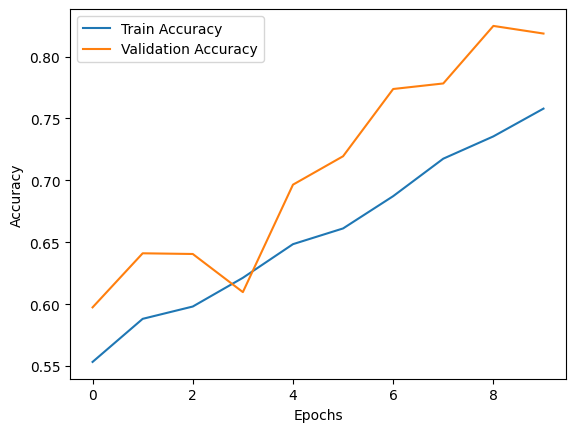

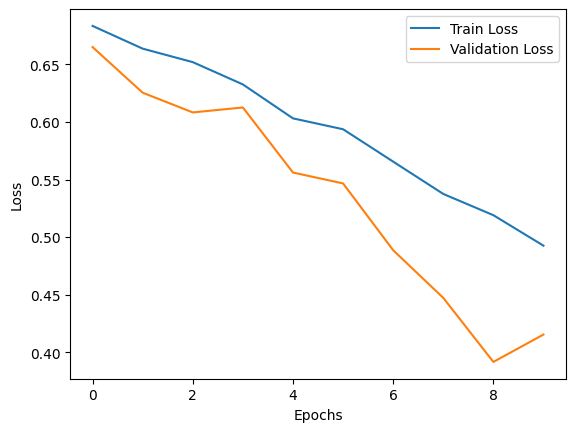

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['recall'], label='Train Recall')
plt.plot(history.history['val_recall'], label='Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()
plt.show()


## MLP Baseline Model for CNN Comparison <a name="baseline_model"></a>
...

In [18]:

test_datagen_mlp = ImageDataGenerator(rescale=1.0/255)

test_generator_mlp = test_datagen_mlp.flow_from_directory(
    test_dir,
    target_size=(150, 150),  
    batch_size=32,
    class_mode='binary'
)

# MLP Baseline Model
mlp_model = Sequential([
     Flatten(input_shape=(150, 150, 3)),
    Dense(1, activation='sigmoid')  # Binary classification
])


mlp_model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(), Recall()]
)

# Training and validation
mlp_history = mlp_model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator
)

# Analysis
mlp_loss, mlp_acc, mlp_precision, mlp_recall = mlp_model.evaluate(test_generator_mlp)
mlp_f1_score = 2 * (mlp_precision * mlp_recall) / (mlp_precision + mlp_recall + 1e-7)
print(f"MLP Accuracy: {mlp_acc:.2f}")
print(f"MLP Precision: {mlp_precision:.4f}")
print(f"MLP Recall: {mlp_recall:.4f}")
print(f"MLP F1 Score: {mlp_f1_score:.4f}")


Found 1794 images belonging to 2 classes.
Epoch 1/5


/Users/kirsten/Library/Python/3.9/lib/python/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


283/283 ━━━━━━━━━━━━━━━━━━━━ 26s 93ms/step - accuracy: 0.5141 - loss: 1.3159 - precision_2: 0.4954 - recall_2: 0.4971 - val_accuracy: 0.5213 - val_loss: 0.7243 - val_precision_2: 0.5129 - val_recall_2: 0.3425
Epoch 2/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - accuracy: 0.5229 - loss: 1.0069 - precision_2: 0.5132 - recall_2: 0.5237 - val_accuracy: 0.5862 - val_loss: 0.8352 - val_precision_2: 0.5457 - val_recall_2: 0.8989
Epoch 3/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 26s 92ms/step - accuracy: 0.5277 - loss: 0.9589 - precision_2: 0.5136 - recall_2: 0.5322 - val_accuracy: 0.5319 - val_loss: 0.8253 - val_precision_2: 0.5121 - val_recall_2: 0.8287
Epoch 4/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 26s 92ms/step - accuracy: 0.5285 - loss: 0.9844 - precision_2: 0.5053 - recall_2: 0.5226 - val_accuracy: 0.5050 - val_loss: 1.2117 - val_precision_2: 0.4563 - val_recall_2: 0.0839
Epoch 5/5
283/283 ━━━━━━━━━━━━━━━━━━━━ 26s 91ms/step - accuracy: 0.5355 - loss: 0.9864 - precision_2: 0.5218 - recall_2: 0.5206 - val_

/Users/kirsten/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - accuracy: 0.7538 - loss: 0.5335 - precision_2: 0.1825 - recall_2: 0.0962
MLP Accuracy: 0.53
MLP Precision: 0.5586
MLP Recall: 0.2111
MLP F1 Score: 0.3064
